In [2]:
!pip install timm

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.4/346.4 kB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 150.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.9/170.9 kB 50.5 MB/s eta 0:00:00
DEPRECATION: flatbuffers 1.12.1-git20200711.33e2d80-dfsg1-0.6 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of flatbuffers or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
import timm
import torch
import torch.nn as nn
import copy
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix
from torchvision import transforms, datasets

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
class CNN_5Layer(nn.Module):
    def __init__(self):
        super(CNN_5Layer, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5),
        )

        dummy_input = torch.randn(1, 3, 224, 224)
        conv_output_size = self._get_conv_output_size(dummy_input)

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_output_size, 4, bias=True),
            nn.Softmax(dim=1)
        )

        self.l1_regularizer = nn.L1Loss()

    def _get_conv_output_size(self, x):
        with torch.no_grad():
            conv_output = self.conv_layers(x)
        return conv_output.view(x.size(0), -1).shape[1]

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [5]:
class CNN_6Layer(nn.Module):
    def __init__(self):
        super(CNN_6Layer, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5),
        )

        dummy_input = torch.randn(1, 3, 224, 224)
        conv_output_size = self._get_conv_output_size(dummy_input)

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_output_size, 4, bias=True),
            nn.Softmax(dim=1)
        )

        self.l1_regularizer = nn.L1Loss()

    def _get_conv_output_size(self, x):
        with torch.no_grad():
            conv_output = self.conv_layers(x)
        return conv_output.view(x.size(0), -1).shape[1]

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [6]:
def create_cnn(model_name):
    if model_name == '5-layer': model = CNN_5Layer()
    if model_name == '6-layer': model = CNN_6Layer()

    return model

In [7]:
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

dataset = datasets.ImageFolder(root='/home/ubuntu/Parkinson-Project/non-keyframes/energy_images', transform=transform)

total_size = len(dataset)
train_size = int(total_size * 0.8) 
validation_size = int(total_size * 0.1) 
test_size = total_size - train_size - validation_size
generator = torch.Generator().manual_seed(0) 
train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [8]:
experiment = 'cnn-5-layer-130-epochs-early-stopping-with-regularization'

In [9]:
model_type = '5-layer'
model = create_cnn(model_type)

# Model summary to check architecture
print(model)

CNN_5Layer(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.5, inplace=False)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.5, inplace=False)
    (15): Conv2d(64, 64, kernel_size=(3, 3), s

In [10]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

num_epochs = 130  
patience = 20  
best_val_loss = float('inf')  
best_model = None  

train_loss_list = list()
val_loss_list = list()
train_accuracy_list = list()
val_accuracy_list = list()

for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    correct = 0
    total = 0
    print(f"Epoch {epoch+1}")

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)  

        optimizer.zero_grad()  
        outputs = model(images)  
        loss = criterion(outputs, labels)  
        loss.backward() 
        optimizer.step() 

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        print(f"Batch {batch_idx+1}, Loss: {loss.item():.6f}, Accuracy: {100 * correct / total:.2f}%")

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    print(f"Training - Epoch {epoch+1}, Loss: {train_loss:.6f}, Accuracy: {train_accuracy:.2f}%")

    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)

    # Validation step
    model.eval()  
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():  
        for batch_idx, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)  

            outputs = model(images) 
            loss = criterion(outputs, labels) 

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            print(f"Validation Batch {batch_idx+1}, Loss: {loss.item():.6f}, Accuracy: {100 * val_correct / val_total:.2f}%")

    val_loss /= len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    print(f"Validation - Epoch {epoch+1}, Loss: {val_loss:.6f}, Accuracy: {val_accuracy:.2f}%")

    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        patience_counter = 0
    else:
        patience_counter += 1

    print(f'Patience—{patience_counter}')

    # Check for early stopping
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

model = best_model
torch.save(model.state_dict(), f'{experiment}-{model_type}')

Using device: cuda:0
Epoch 1
Batch 1, Loss: 1.387073, Accuracy: 29.69%
Batch 2, Loss: 1.387005, Accuracy: 28.91%
Batch 3, Loss: 1.343186, Accuracy: 30.21%
Batch 4, Loss: 1.373602, Accuracy: 30.47%
Batch 5, Loss: 1.384724, Accuracy: 30.00%
Batch 6, Loss: 1.337503, Accuracy: 31.51%
Batch 7, Loss: 1.336178, Accuracy: 30.80%
Batch 8, Loss: 1.307613, Accuracy: 32.42%
Batch 9, Loss: 1.361801, Accuracy: 32.29%
Batch 10, Loss: 1.327869, Accuracy: 32.66%
Batch 11, Loss: 1.330405, Accuracy: 32.53%
Batch 12, Loss: 1.299042, Accuracy: 33.46%
Batch 13, Loss: 1.394024, Accuracy: 33.05%
Batch 14, Loss: 1.358895, Accuracy: 32.59%
Batch 15, Loss: 1.344712, Accuracy: 32.92%
Batch 16, Loss: 1.288465, Accuracy: 33.20%
Batch 17, Loss: 1.278545, Accuracy: 33.82%
Batch 18, Loss: 1.341334, Accuracy: 33.85%
Batch 19, Loss: 1.299443, Accuracy: 34.21%
Batch 20, Loss: 1.297258, Accuracy: 34.30%
Batch 21, Loss: 1.319953, Accuracy: 34.45%
Batch 22, Loss: 1.264321, Accuracy: 35.01%
Batch 23, Loss: 1.219920, Accuracy

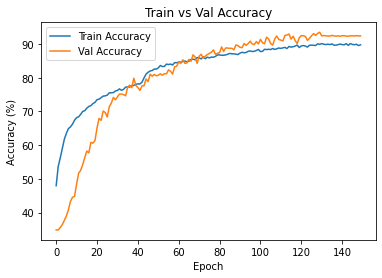

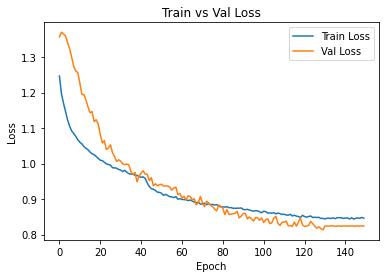

In [18]:
import matplotlib.pyplot as plt

plt.plot(train_accuracy_list, label='Train Accuracy')

# Plotting the second graph
plt.plot(val_accuracy_list, label='Val Accuracy')

# Adding labels and a legend
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Val Accuracy')
plt.legend()

# Display the plot
plt.show()

plt.plot(train_loss_list, label='Train Loss')

# Plotting the second graph
plt.plot(val_loss_list, label='Val Loss')

# Adding labels and a legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Val Loss')
plt.legend()

# Display the plot
plt.show()

In [17]:
model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        print(f"Test Batch {batch_idx+1}, Loss: {loss.item():.6f}, Accuracy: {100 * test_correct / test_total:.2f}%")

test_loss /= len(test_loader)
test_accuracy = 100 * test_correct / test_total

print(f"Test Set - Loss: {test_loss:.6f}, Accuracy: {test_accuracy:.2f}%")

cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

Test Batch 1, Loss: 0.847946, Accuracy: 89.06%
Test Batch 2, Loss: 0.826492, Accuracy: 89.84%
Test Batch 3, Loss: 0.830174, Accuracy: 91.15%
Test Batch 4, Loss: 0.807507, Accuracy: 91.80%
Test Batch 5, Loss: 0.791317, Accuracy: 92.50%
Test Batch 6, Loss: 0.835469, Accuracy: 92.45%
Test Batch 7, Loss: 0.807470, Accuracy: 92.41%
Test Batch 8, Loss: 0.831125, Accuracy: 92.38%
Test Batch 9, Loss: 0.814786, Accuracy: 92.36%
Test Batch 10, Loss: 0.857463, Accuracy: 92.03%
Test Batch 11, Loss: 0.886698, Accuracy: 91.34%
Test Batch 12, Loss: 0.773976, Accuracy: 91.93%
Test Batch 13, Loss: 0.845479, Accuracy: 91.83%
Test Batch 14, Loss: 0.877339, Accuracy: 91.52%
Test Batch 15, Loss: 0.903838, Accuracy: 91.04%
Test Batch 16, Loss: 0.839689, Accuracy: 90.92%
Test Batch 17, Loss: 0.827635, Accuracy: 91.08%
Test Batch 18, Loss: 0.898265, Accuracy: 90.62%
Test Batch 19, Loss: 0.836514, Accuracy: 90.71%
Test Batch 20, Loss: 0.827211, Accuracy: 90.86%
Test Batch 21, Loss: 0.800165, Accuracy: 91.07%
T

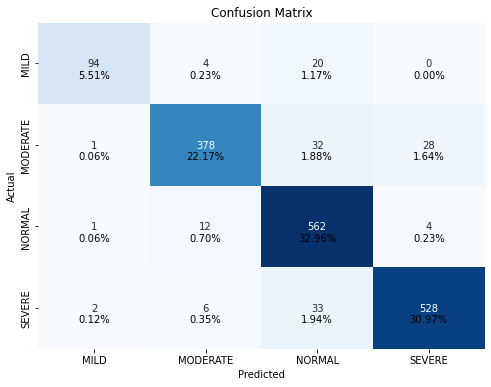

Accuracy: 0.92


In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

cm = confusion_matrix(all_labels, all_predictions)

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_predictions)

# Calculate percentages for each element
cm_percentage = (cm / np.sum(cm)) * 100

# Plot confusion matrix with count and percentages
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['MILD', 'MODERATE', 'NORMAL', 'SEVERE'],
            yticklabels=['MILD', 'MODERATE', 'NORMAL', 'SEVERE'],
            ax=ax)

# Annotate each box with count and percentage
for i in range(len(cm)):
    for j in range(len(cm[0])):
        ax.text(j + 0.5, i + 0.5, f'\n\n{cm_percentage[i, j]:.2f}%',
                ha='center', va='center', color='black')

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(f'Accuracy: {accuracy:.2f}')

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

num_epochs = 130  
patience = 20   

for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    correct = 0
    total = 0
    print(f"Epoch {epoch+1}")

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)  

        optimizer.zero_grad()  
        outputs = model(images)  
        loss = criterion(outputs, labels)  
        loss.backward() 
        optimizer.step() 

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        print(f"Batch {batch_idx+1}, Loss: {loss.item():.6f}, Accuracy: {100 * correct / total:.2f}%")

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    print(f"Training - Epoch {epoch+1}, Loss: {train_loss:.6f}, Accuracy: {train_accuracy:.2f}%")

    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)

    # Validation step
    model.eval()  
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():  
        for batch_idx, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)  

            outputs = model(images) 
            loss = criterion(outputs, labels) 

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            print(f"Validation Batch {batch_idx+1}, Loss: {loss.item():.6f}, Accuracy: {100 * val_correct / val_total:.2f}%")

    val_loss /= len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    print(f"Validation - Epoch {epoch+1}, Loss: {val_loss:.6f}, Accuracy: {val_accuracy:.2f}%")

    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        patience_counter = 0
    else:
        patience_counter += 1

    print(f'Patience—{patience_counter}')

    # Check for early stopping
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

model = best_model
torch.save(model.state_dict(), f'{experiment}-{model_type}')

Using device: cuda:0
Epoch 1
Batch 1, Loss: 0.841388, Accuracy: 89.06%
Batch 2, Loss: 0.812646, Accuracy: 91.41%
Batch 3, Loss: 0.808003, Accuracy: 92.19%
Batch 4, Loss: 0.788760, Accuracy: 93.36%
Batch 5, Loss: 0.817542, Accuracy: 93.12%
Batch 6, Loss: 0.819458, Accuracy: 92.97%
Batch 7, Loss: 0.780254, Accuracy: 93.53%
Batch 8, Loss: 0.791852, Accuracy: 93.75%
Batch 9, Loss: 0.805788, Accuracy: 93.75%
Batch 10, Loss: 0.824610, Accuracy: 93.59%
Batch 11, Loss: 0.925936, Accuracy: 92.61%
Batch 12, Loss: 0.857345, Accuracy: 92.32%
Batch 13, Loss: 0.851434, Accuracy: 92.19%
Batch 14, Loss: 0.852566, Accuracy: 91.85%
Batch 15, Loss: 0.857027, Accuracy: 91.67%
Batch 16, Loss: 0.813333, Accuracy: 91.80%
Batch 17, Loss: 0.856240, Accuracy: 91.64%
Batch 18, Loss: 0.825944, Accuracy: 91.67%
Batch 19, Loss: 0.838109, Accuracy: 91.61%
Batch 20, Loss: 0.906427, Accuracy: 91.17%
Batch 21, Loss: 0.861461, Accuracy: 91.07%
Batch 22, Loss: 0.852954, Accuracy: 90.98%
Batch 23, Loss: 0.854358, Accuracy